In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import networkx as nx
from collections import Counter
from sklearn.preprocessing import MinMaxScaler 
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import random
import uproot

In [3]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Load data

In [4]:
path_to_tree = "DecayTreeTuple/tuple"

def rename_columns(df):
    new_columns = {}
    for col in df.columns:
        if "_BDTTag_" in col:
            new_columns[col] = col.replace("_BDTTag_", "_SVtag_")
    df.rename(columns=new_columns, inplace=True)

# maybe don't need
def extract_float(awk_array):
    return awk_array[0] if len(awk_array) > 0 else None

In [5]:
# Read the ROOT file
tree = uproot.open("Dijet_bb_pt20_50_dw.root" + ":" + path_to_tree)
bb_df = tree.arrays(tree.keys(), library="pd")#, entry_start=0, entry_stop=1000)

# Clean column names and remove unwanted columns
bb_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in bb_df.columns]
rename_columns(bb_df)
columns_to_remove = [col for col in bb_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
bb_df.drop(columns=columns_to_remove, inplace=True)
for col in bb_df.columns:
    if "SVtag" in col:
        bb_df[col] = bb_df[col].apply(extract_float)
tree.close()

# Read the ROOT file
tree = uproot.open("Dijet_qq_pt20_50_dw.root" + ":" + path_to_tree)
qq_df = tree.arrays(tree.keys(), library="pd")#, entry_start=0, entry_stop=1000)

# Clean column names and remove unwanted columns
qq_df.columns = [col.rstrip('_') if col.endswith('_') else col for col in qq_df.columns]
rename_columns(qq_df)
columns_to_remove = [col for col in qq_df.columns if (col.startswith("H_10") or col.endswith("COV") or ("Decision" in col) or col.endswith("Tag") or col.endswith("NbTag") )]
qq_df.drop(columns=columns_to_remove, inplace=True)
for col in qq_df.columns:
    if "SVtag" in col:
        qq_df[col] = qq_df[col].apply(extract_float)
tree.close()

/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/data/home/pesticci/.conda/envs/gnn_env/lib/python3.9/site-packages/uproot/interpretation/library.py:795: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

In [6]:
# Read from csv and assign truth labels
sig_df = bb_df.assign(IsB=1)
bkg_df = qq_df.assign(IsB=0)

# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Only include leading jet data and truth labels
sig_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

# Truth matching and cuts
sig_df = sig_df[(sig_df['Jet0_MC_Match'] == 1) &
                (sig_df['Jet0_MC_Jet_EfB'] > 0.6) &
                (sig_df['Jet0_PT'] > 20000) &
                (sig_df['Jet0_Eta'].between(2.2, 4.4))]
bkg_df = bkg_df[(bkg_df['Jet0_MC_Match'] == 1) &
                (bkg_df['Jet0_MC_Jet_EfB'] < 0.6) &
                (bkg_df['Jet0_MC_Jet_EfD'] < 0.6) &
                (bkg_df['Jet0_PT'] > 20000) &
                (bkg_df['Jet0_Eta'].between(2.2, 4.4))]

# Combine signal and background
combined_df = pd.concat([sig_df, bkg_df]).reset_index(drop=True)
print(f'Length of combined data is: {len(combined_df)}')

# Define daughter and jet-level features, including sv tagging
daughter_cols = [col for col in sig_df.columns if "_Daughters" in col]
svtag_cols = ['Jet0_SVtag_fdrMin',
 'Jet0_SVtag_ptSvrJet',
 'Jet0_SVtag_nTrk',
 'Jet0_SVtag_nTrkJet',
 'Jet0_SVtag_drSvrJet',
 'Jet0_SVtag_absQSum',
 'Jet0_SVtag_m',
 'Jet0_SVtag_mCor',
 'Jet0_SVtag_fdChi2',
 'Jet0_SVtag_ipChi2Sum',
 'Jet0_SVtag_tau',
 'Jet0_SVtag_z',
 'Jet0_SVtag_pt']
jet_cols = ['Jet0_Eta', 'Jet0_PT'] + svtag_cols
feature_cols = daughter_cols + jet_cols

Length of combined data is: 1312597


In [7]:
for col in daughter_cols:
    combined_df[col] = combined_df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)

In [8]:
# Split data into training, validation, and test sets
sig_df = combined_df[combined_df['IsB'] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
bkg_df = combined_df[combined_df['IsB'] == 0].sample(frac=1, random_state=42).reset_index(drop=True)

half_train_size = int((sum(combined_df.IsB)*0.8)/2)
half_test_size = int((sum(combined_df.IsB)*0.2)/2)

train_df = pd.concat([sig_df.head(half_train_size), bkg_df.head(half_train_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of training data is: {len(train_df)}')

test_df = pd.concat([sig_df.tail(half_test_size), bkg_df.tail(half_test_size)]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of testing data is: {len(test_df)}')

validation_df = pd.concat([sig_df.iloc[half_train_size:-half_test_size], bkg_df.iloc[half_train_size:-half_test_size]]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f'Length of validation data is: {len(validation_df)}')

Length of training data is: 503670
Length of testing data is: 125916
Length of validation data is: 683011


In [9]:
train_sig_df = train_df[train_df['IsB'] == 1]
train_bkg_df = train_df[train_df['IsB'] == 0]

full_sig_df = combined_df[combined_df['IsB'] == 1]
full_bkg_df = combined_df[combined_df['IsB'] == 0]

Plot features data

In [10]:
def get_lists(col):
    sig_list = []
    bkg_list = []

    for i, row in train_sig_df.iterrows():
        vals = row[col]
        if isinstance(vals, list):
            sig_list.extend(vals)
        else:
            sig_list.append(vals)

    for i, row in train_bkg_df.iterrows():
        vals = row[col]
        if isinstance(vals, list):
            bkg_list.extend(vals)
        else:
            bkg_list.append(vals)
    return sig_list, bkg_list

In [10]:
E_sig, E_bkg = get_lists('Jet0_Daughters_E')
PT_sig, PT_bkg = get_lists('Jet0_PT')

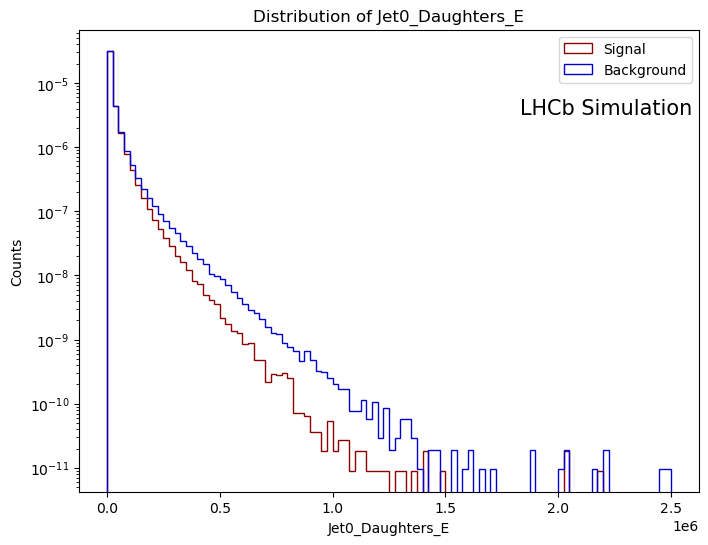

In [11]:
plt.figure(figsize=(8, 6))
plt.hist(E_sig, label="Signal", range=[0,2.5e6], bins=100, histtype='step', color='darkred', density=True)
plt.hist(E_bkg, label="Background", range=[0,2.5e6], bins=100, histtype='step', color='mediumblue', density=True)
plt.text(0.85, 0.83, "LHCb Simulation", fontsize=15, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('Jet0_Daughters_E')
plt.ylabel('Counts')
plt.yscale('log')
plt.title('Distribution of Jet0_Daughters_E')
plt.legend(loc='best')
plt.show()

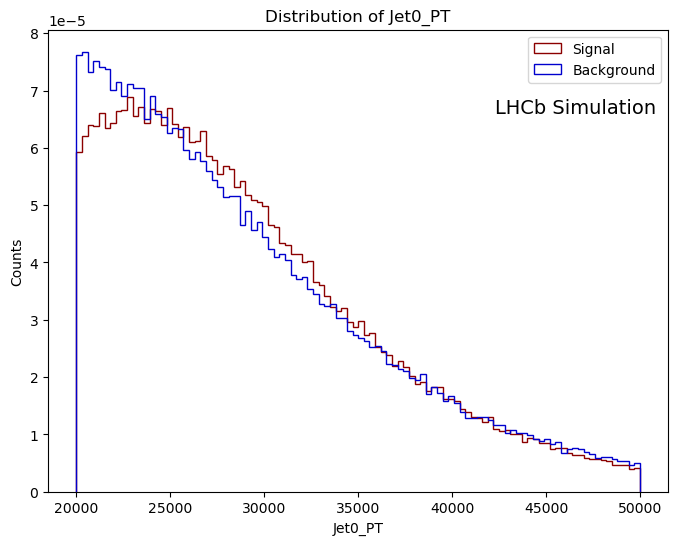

In [12]:
plt.figure(figsize=(8, 6))
plt.hist(PT_sig, label="Signal", range=[20000,50000], bins=100, histtype='step', color='darkred', density=True)
plt.hist(PT_bkg, label="Background", range=[20000,50000], bins=100, histtype='step', color='mediumblue', density=True)
plt.text(0.85, 0.83, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('Jet0_PT')
plt.ylabel('Counts')
plt.yscale('linear')
plt.title('Distribution of Jet0_PT')
plt.legend(loc='best')
plt.show()

In [13]:
def plot_features(col, scale, range, bins, x, y):
    sig_list, bkg_list = get_lists(col)

    plt.figure(figsize=(8, 6))
    plt.hist(sig_list, label="Signal", range=range, bins=bins, histtype='step', color='darkred', density=True)
    plt.hist(bkg_list, label="Background", range=range, bins=bins, histtype='step', color='mediumblue', density=True)
    plt.xlabel(f'{col}')
    plt.ylabel('Counts')
    plt.yscale(scale)
    plt.title(f'Distribution of {col}')
    plt.text(x, y, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
    plt.legend(loc='best')
    plt.show()

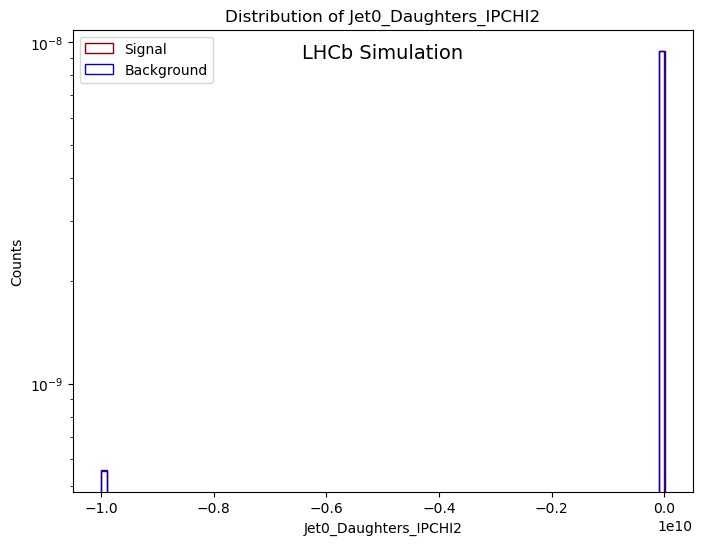

In [14]:
plot_features('Jet0_Daughters_IPCHI2', 'log', None, 100, .5, .95)

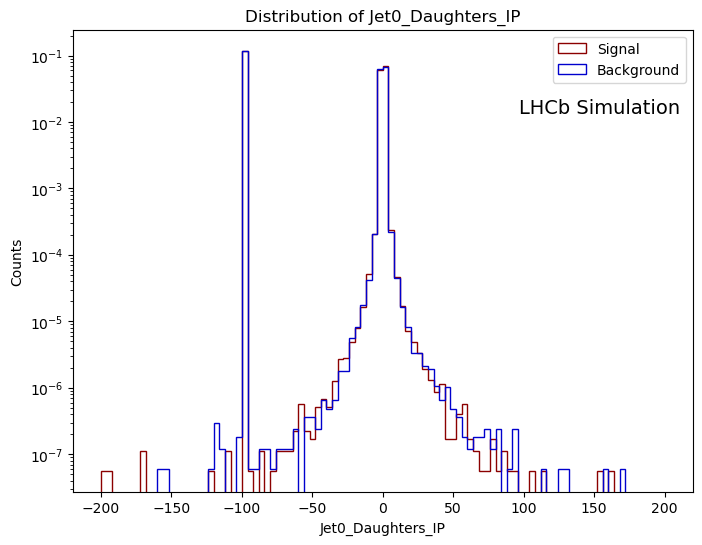

In [15]:
plot_features('Jet0_Daughters_IP', 'log', [-200, 200], 100, 0.85, 0.83)

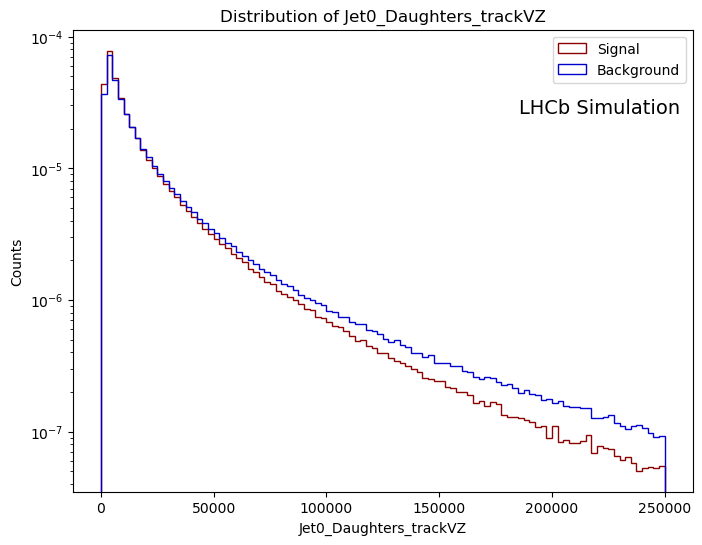

In [16]:
plot_features('Jet0_Daughters_trackVZ', 'log', [0,0.25e6], 100, 0.85, 0.83)

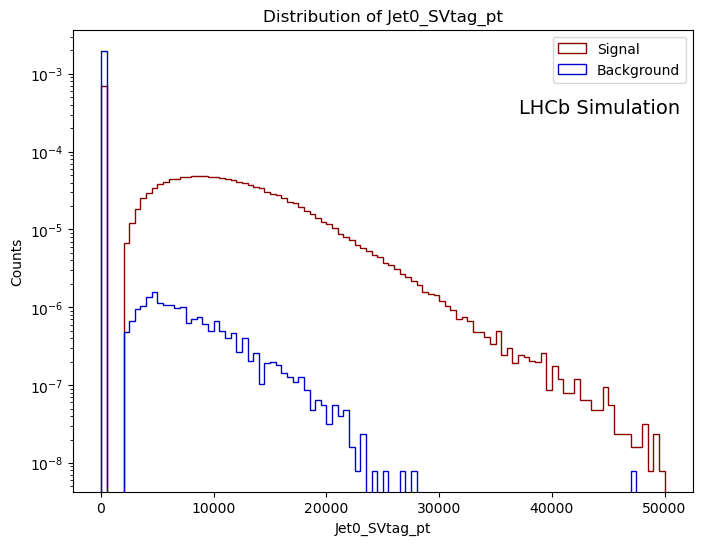

In [17]:
plot_features('Jet0_SVtag_pt', 'log', [0,50000], 100, 0.85, 0.83)

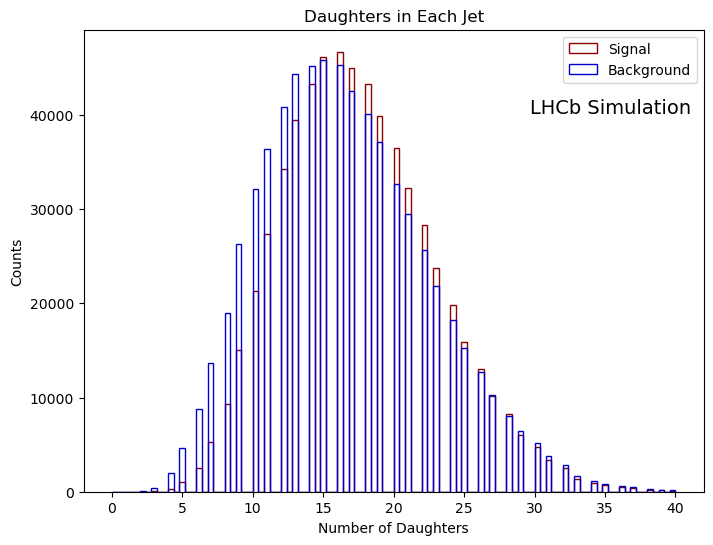

In [18]:
plt.figure(figsize=(8, 6))
plt.hist(sig_df.Jet0_nDaughters, label="Signal", range=[0,40], bins=100, histtype='step', color='darkred')
plt.hist(bkg_df.Jet0_nDaughters, label="Background", range=[0,40], bins=100, histtype='step', color='mediumblue')
plt.text(0.85, 0.83, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('Number of Daughters')
plt.ylabel("Counts")
plt.legend(loc='best')
plt.title('Daughters in Each Jet'); 
plt.show()

In [11]:
sig_id_list = []
bkg_id_list = []

for i, row in sig_df.iterrows():
    numbers = [float(num) for num in row['Jet0_Daughters_ID']]
    sig_id_list.extend(numbers)

for i, row in bkg_df.iterrows():
    numbers = [float(num) for num in row['Jet0_Daughters_ID']]
    bkg_id_list.extend(numbers)

In [12]:
sig_id_counts = Counter(sig_id_list)
bkg_id_counts = Counter(bkg_id_list)

In [13]:
sig_id_counts

Counter({22.0: 4510332,
         -22.0: 614728,
         211.0: 2150943,
         -211.0: 2112428,
         -321.0: 259734,
         111.0: 104734,
         -11.0: 136347,
         3122.0: 43144,
         321.0: 265780,
         310.0: 357986,
         11.0: 132134,
         2212.0: 93323,
         -2212.0: 89479,
         -3122.0: 43958,
         -13.0: 48357,
         13.0: 47367})

In [14]:
bkg_id_counts

Counter({22.0: 4620186,
         211.0: 2306711,
         -211.0: 2245110,
         321.0: 287480,
         111.0: 117264,
         11.0: 120458,
         310.0: 174052,
         -321.0: 275755,
         2212.0: 169267,
         -22.0: 632280,
         -11.0: 125204,
         -2212.0: 160558,
         13.0: 10121,
         -13.0: 10438,
         3122.0: 24177,
         -3122.0: 25404})

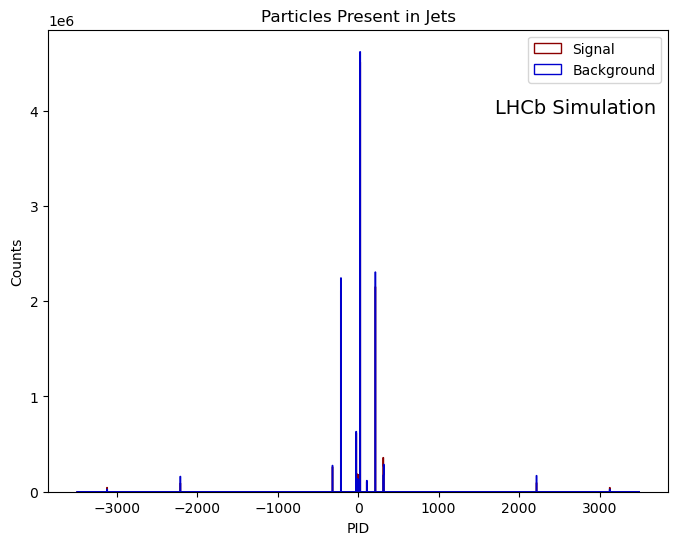

In [15]:
# Plot of Jet 0 Daughters PID (not including some outliers)
plt.figure(figsize=(8, 6))
plt.hist(sig_id_list, label='Signal', bins=1000, range=[-3500,3500], histtype='step', color='darkred')
plt.hist(bkg_id_list, label='Background', bins=1000, range=[-3500,3500], histtype='step', color='mediumblue')
'''
plt.text(-3000, 100000, '-3122: Λ', horizontalalignment='center', verticalalignment='center')
plt.text(-2200, 200000, '-2212: p$^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-1500, 100000, '-321: K $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 200000, '-211: π $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 300000, '-22: γ', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 400000, '-13: µ $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(-1500, 500000, '-11: e $^{+}$', horizontalalignment='left', verticalalignment='center')

plt.text(700, 700000, '11: e $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 600000, '13: µ $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 500000, '22: γ', horizontalalignment='left', verticalalignment='center')
plt.text(700, 400000, '211: π $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 300000, '111: π $^{0}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 200000, '310: K$^{0}_{s}$', horizontalalignment='left', verticalalignment='center')
plt.text(700, 100000, '321: K $^{+}$', horizontalalignment='left', verticalalignment='center')
plt.text(2200, 200000, '2212: p$^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(3000, 100000, '3122: Λ', horizontalalignment='center', verticalalignment='center')'''
plt.text(0.85, 0.83, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('PID');
plt.ylabel('Counts');
plt.title('Particles Present in Jets');
plt.legend(loc='best');
plt.show()

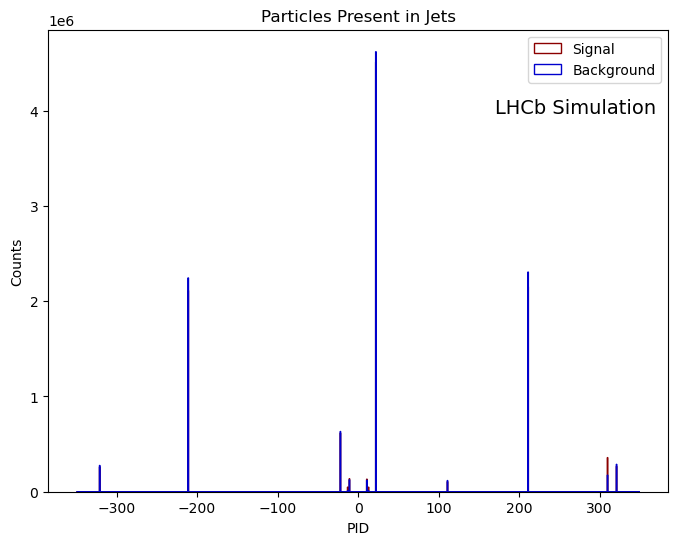

: 

In [ ]:
# Plot of Daughters PID in range of pions and kaons
plt.figure(figsize=(8, 6))
plt.hist(sig_id_list, label='Signal', bins=1000, range=[-350,350], histtype='step', color='darkred')
plt.hist(bkg_id_list, label='Background', bins=1000, range=[-350,350], histtype='step', color='mediumblue')
'''
plt.text(-300, 200000, '-321: K $^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-200, 800000, '-211: π $^{-}$', horizontalalignment='center', verticalalignment='center')
plt.text(-25, 300000, '-22: γ', horizontalalignment='center', verticalalignment='center')
plt.text(-100, 200000, '-13: µ $^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(-100, 100000, '-11: e $^{+}$', horizontalalignment='center', verticalalignment='center')

plt.text(90, 100000, '11: e $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(90, 200000, '13: µ $^{-}$', horizontalalignment='left', verticalalignment='center')
plt.text(-25, 1400000, '22: γ', horizontalalignment='center', verticalalignment='center')
plt.text(90, 300000, '111: π $^{0}$', horizontalalignment='left', verticalalignment='center')
plt.text(211, 850000, '211: π $^{+}$', horizontalalignment='center', verticalalignment='center')
plt.text(280, 250000, '310: K$^{0}_{s}$', horizontalalignment='left', verticalalignment='center')
plt.text(280, 350000, '321: K $^{+}$', horizontalalignment='left', verticalalignment='center')'''

plt.text(0.85, 0.83, "LHCb Simulation", fontsize=14, transform=plt.gca().transAxes, verticalalignment='center', horizontalalignment='center')
plt.xlabel('PID');
plt.ylabel('Counts');
plt.title('Particles Present in Jets');
plt.legend(loc='best');
plt.show()